# KickStater Project

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

%matplotlib inline

## Load and Galance Dataset

In [2]:
raw_data = pd.read_csv('../dataset/MasterKickstarter.csv')
raw_data.head()

,Unnamed: 0,X1,X1_1,Country,City,id,name,blurb,goal,pledged,...,Backers_as_Prct_of_Pop_YM,Backers_as_Prct_of_Pop_Y,Days_spent_making_campign,Days_inception_to_Deadline,Backers_in_city_Y,Backers_in_city_YM,All_Time_Backers_city,Mean_Pledge_City,Mean_pledge_city_Y,Mean_pledge_city_YM
0,1,1,1,AUS,Adelaide,1337161279,"Worlds & Creatures, the Art of Anthony Christou",A 100 page Artbook featuring the work of Antho...,5000.0,16081.00,...,0.020015,0.044034,21,59,473,215,1672,3124.0,2975.532222,215.0
1,2,2,2,AUS,Adelaide,1533913565,Pheonician Entertainment Productions,"Wordsmith! The story of good vs Evil, Hero vs ...",5500.0,257.00,...,0.000465,0.044034,22,62,473,5,1672,3124.0,2975.532222,2.5
2,3,3,3,AUS,Adelaide,1666009607,The Postnatalist - Second issue comic book,The Postnatalist explores feminist issues invo...,300.0,353.12,...,0.000838,0.000931,3,48,10,9,1672,3124.0,94.440000,4.5
3,4,4,4,AUS,Adelaide,1759296231,Alkandros: Futurewear 3000 Square Sunglasses; ...,Alkandros Designs is interested in being diffe...,5000.0,90.00,...,0.000279,0.044034,84,144,473,3,1672,3124.0,2975.532222,3.0
4,5,5,5,AUS,Adelaide,458085213,School of the Road: Autism and Adventure Docum...,A feature length documentary and educational s...,100000.0,16272.56,...,0.009310,0.044034,68,103,473,100,1672,3124.0,2975.532222,100.0


## Generate correlation map, analyze feature correlations in order to reduce feature dimension 

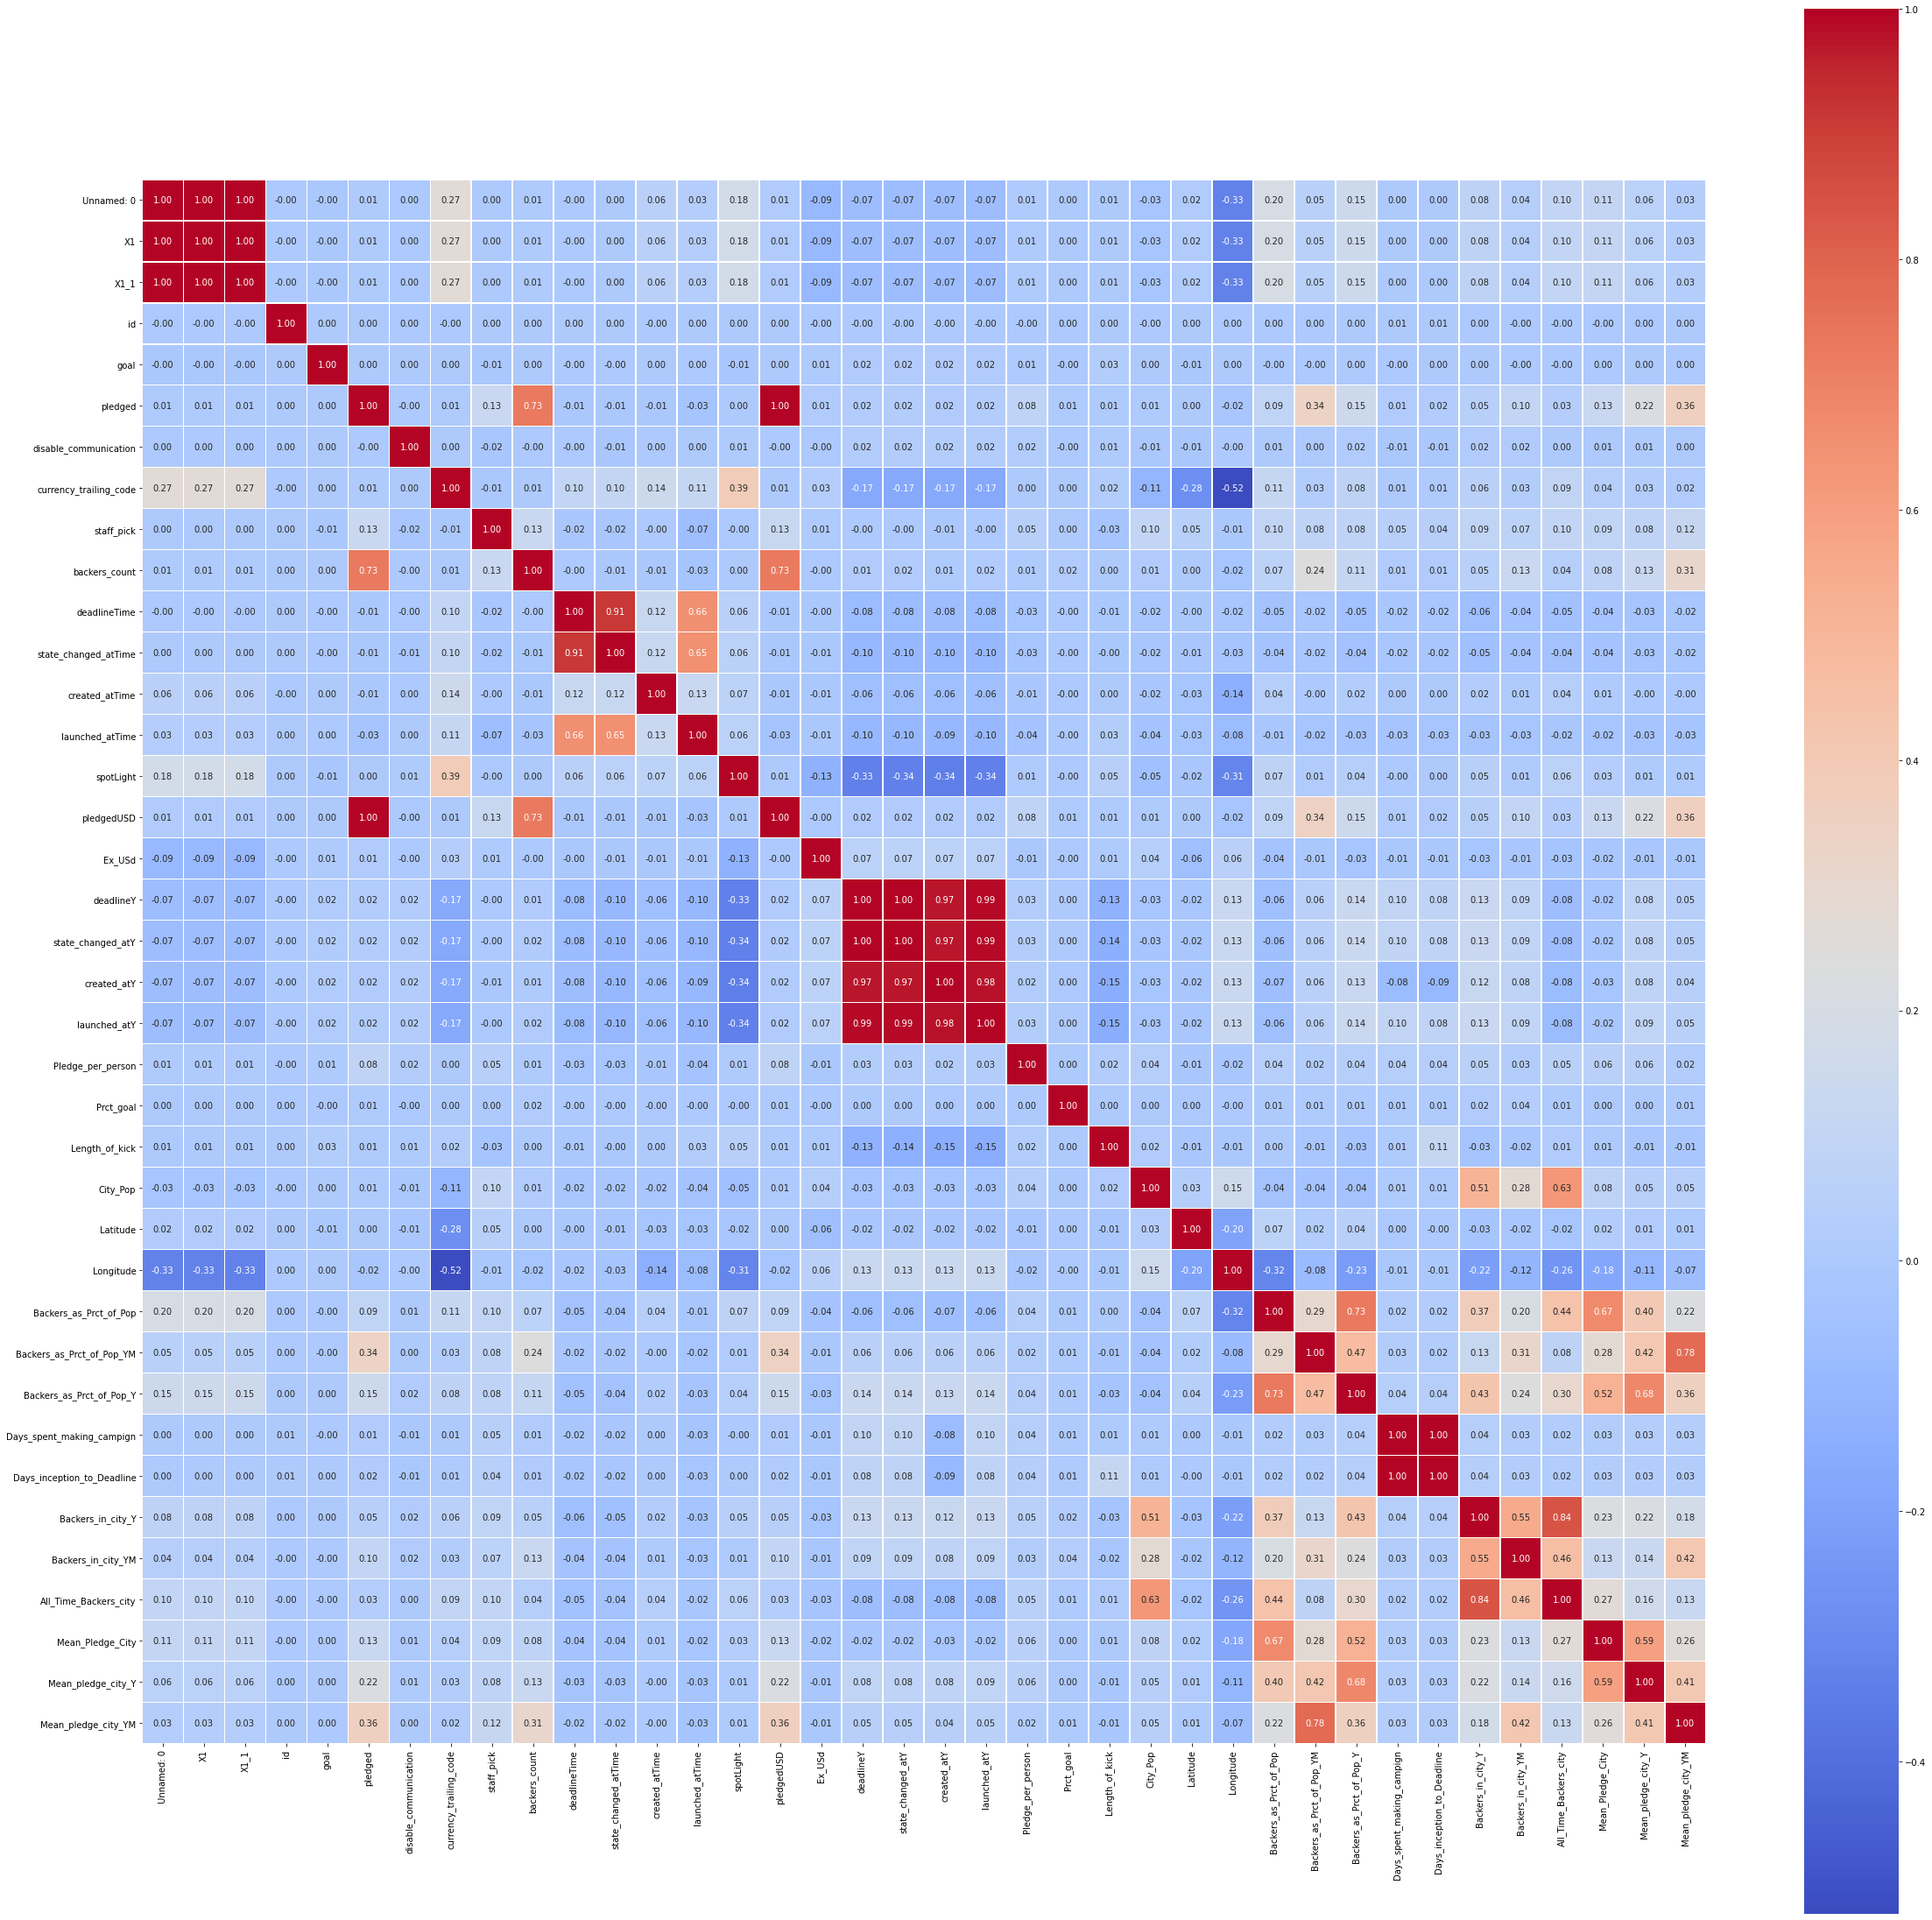

In [3]:
## Replace NULL with 0
raw_data.fillna(0)
plt.figure(figsize=(40, 40)) 
raw_corr = raw_data.corr()
h1 = sns.heatmap(raw_corr, square=True, linewidths=.5, annot=True, fmt='.2f', cmap='coolwarm')
plt.savefig("raw_corr.png")

## Drop the high correlated feartures

In [4]:
uncorr_data = raw_data.drop(['Unnamed: 0', 'X1', 'X1_1', 'disable_communication', 'currency', 'currency_symbol', 'currency_trailing_code', 'id','deadline', 'state_changed_at', 'created_at','launched_at', 'pledged', 'pledgedUSD', 'Prct_goal', 'Backers_as_Prct_of_Pop', 'Backers_as_Prct_of_Pop_YM', 'Backers_as_Prct_of_Pop_Y', 'Days_inception_to_Deadline','deadlineTime','state_changed_atTime', 'created_atTime', 'launched_atTime',
       'state_changed_atY', 'created_atY', 'launched_atY', 'deadlineYM', 'state_changed_atYM', 'created_atYM', 'launched_atYM', 'Mean_pledge_city_Y', 'Mean_pledge_city_YM', 'Backers_in_city_YM', 'Backers_in_city_Y'], axis = 1)

## Combine two features to a single new feature

In [5]:
uncorr_data['goal_USD'] = uncorr_data['goal'] / uncorr_data['Ex_USd']

uncorr_data = uncorr_data.drop(['goal', 'Ex_USd'], axis = 1)

## Only choose successful and failed data to analysis

In [6]:
uncorr_data.query("status in ['failed', 'successful']", inplace=True)

## Convert non_numerical_data into binary value as categorical encoding

In [7]:
def handle_non_numerical_data(df):
    columns = ['Country', 'City', 'County', 'status', 'State', 'Categories', 'spotLight', 'staff_pick']
    
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]
        
        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = bin(x)[2:]
                    x+=1
            df[column] = list(map(convert_to_int, df[column]))
  
    return df

binary_uncorr_data = handle_non_numerical_data(uncorr_data)

## Drop missing value by row

In [8]:
real_binary_uncorr_data = binary_uncorr_data.dropna(axis = 0)

## Based on the numerical data, generate new correlation map

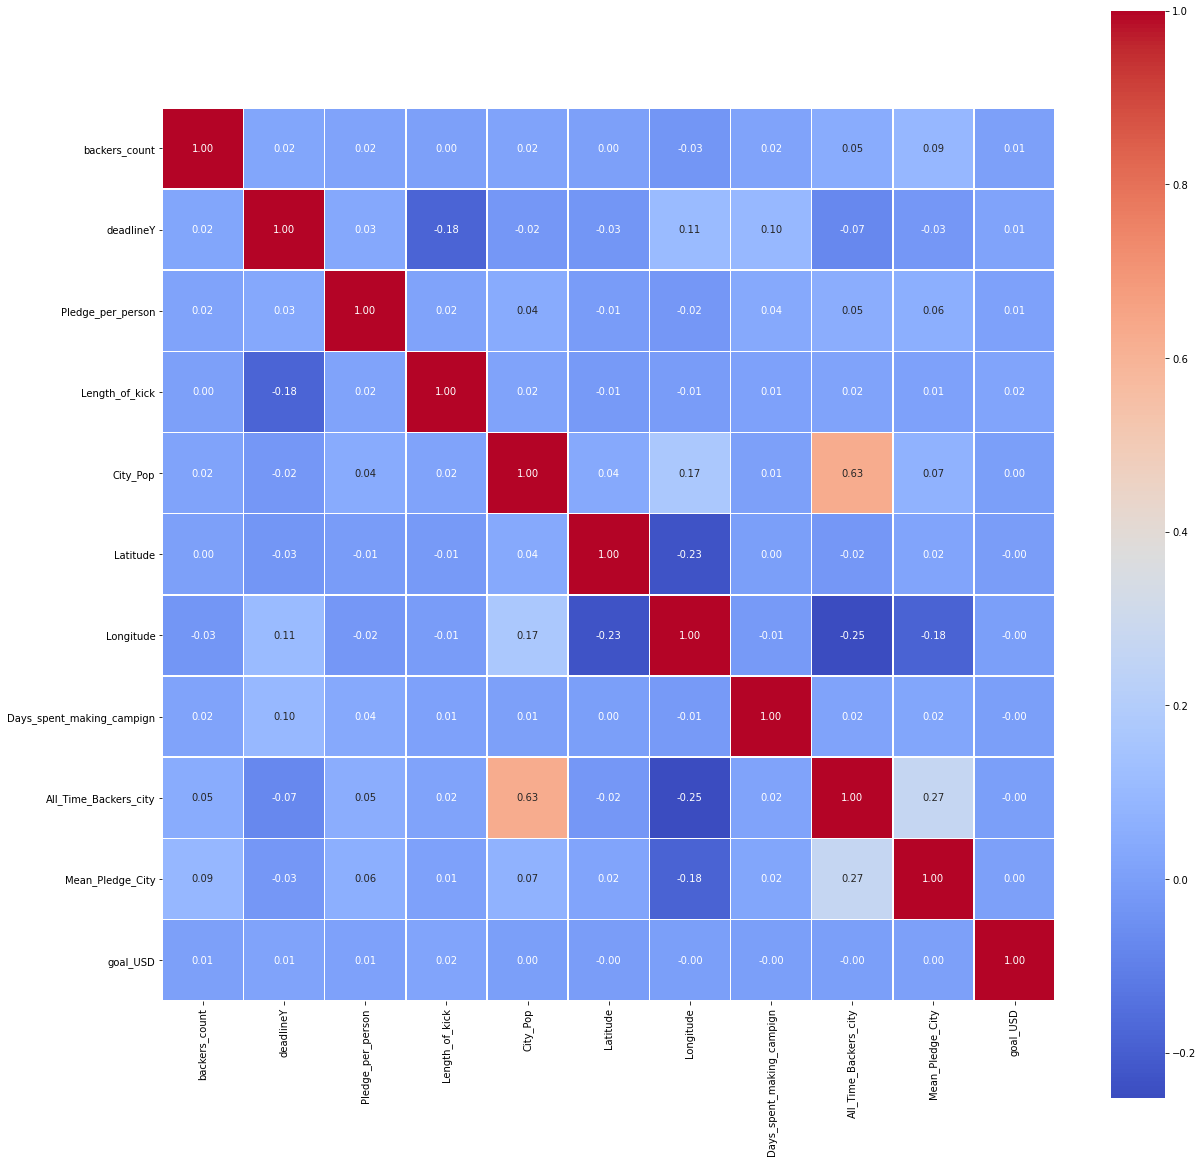

In [9]:
plt.figure(figsize=(20, 20)) 
real_corr = real_binary_uncorr_data.corr()
h2 = sns.heatmap(real_corr, square=True, linewidths=.5, annot=True, fmt='.2f', cmap='coolwarm')
plt.savefig("real_corr.png")

## Scaling features

In [10]:
scall_data = real_binary_uncorr_data
for col in ['backers_count', 'Length_of_kick', 'City_Pop', 'Days_spent_making_campign', 'All_Time_Backers_city', 'goal_USD', 'Pledge_per_person', 'Mean_Pledge_City']:
    sc = StandardScaler(with_mean=True, with_std=True)
    scall_data[col] = sc.fit_transform(scall_data[col].values.reshape(-1,1))

## Generate new features based on 'name' and 'blurb'

In [11]:
scall_data['len_name'] = scall_data.name.str.len()
scall_data['word_name'] = scall_data.name.apply(lambda w: len(str(w).split(' ')))
scall_data['word_name_radio'] = scall_data.word_name / scall_data.len_name
scall_data['len_blurb'] = scall_data.blurb.str.len()
scall_data['word_blurb'] = scall_data.blurb.apply(lambda w: len(str(w).split(' ')))
scall_data['word_blurb_radio'] = scall_data.word_blurb / scall_data.len_blurb

final_data = scall_data.drop(['name','blurb'], axis = 1)

## Divide final dataset into value X and label Y

In [12]:
X = final_data.drop(['slug', 'status'], axis = 1)
Y = final_data.status

## Divide X into training dataset and test dataset

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

# Classcification System Result
## Use SVM model

In [14]:
rbf_classifier = SVC()
rbf_classifier.fit(X_train, y_train)

SVM_Y_pred = rbf_classifier.predict(X_test)

print('SVM classification report \n',classification_report(y_test, SVM_Y_pred))
print('SVM confusion_matrix \n',confusion_matrix(y_test, SVM_Y_pred),'\n')
print('SVM accuracy is', accuracy_score(SVM_Y_pred, y_test))

SVM classification report 
               precision    recall  f1-score   support

           0       0.53      0.25      0.34      8868
           1       0.52      0.78      0.62      9141

    accuracy                           0.52     18009
   macro avg       0.52      0.52      0.48     18009
weighted avg       0.52      0.52      0.48     18009

SVM confusion_matrix 
 [[2217 6651]
 [1977 7164]] 

SVM accuracy is 0.5209062135598868


## Use MLPNN model

In [15]:
MLPNN = MLPClassifier(learning_rate = 'adaptive', max_iter = 1000, verbose = False)
MLPNN.fit(X_train, y_train)

MLPNN_Y_pred = MLPNN.predict(X_test)

print(classification_report(y_test, MLPNN_Y_pred))
print(confusion_matrix(y_test, MLPNN_Y_pred))
print('accuracy of MLPNN:', accuracy_score(y_test, MLPNN_Y_pred))

              precision    recall  f1-score   support

           0       0.50      0.84      0.62      8868
           1       0.53      0.18      0.27      9141

    accuracy                           0.50     18009
   macro avg       0.51      0.51      0.45     18009
weighted avg       0.52      0.50      0.44     18009

[[7448 1420]
 [7525 1616]]
accuracy of MLPNN: 0.5033039036037537


## Use KNN model

In [16]:
neighbors = int(sqrt(X_train.shape[0] / 2))
KNN = KNeighborsClassifier(n_neighbors=neighbors)
KNN.fit(X_train, y_train)

KNN_Y_pred = KNN.predict(X_test)
    
print(classification_report(y_test, KNN_Y_pred))
print(confusion_matrix(y_test, KNN_Y_pred))
print('accuracy of KNN:', accuracy_score(y_test, KNN_Y_pred))

              precision    recall  f1-score   support

           0       0.58      0.59      0.59      8868
           1       0.60      0.58      0.59      9141

    accuracy                           0.59     18009
   macro avg       0.59      0.59      0.59     18009
weighted avg       0.59      0.59      0.59     18009

[[5264 3604]
 [3824 5317]]
accuracy of KNN: 0.5875395635515576


## Use Decision Tree

In [17]:
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)

DT_Y_pred = DT.predict(X_test)
    
print(classification_report(y_test, DT_Y_pred))
print(confusion_matrix(y_test, DT_Y_pred))
print('accuracy of DT:', accuracy_score(y_test, DT_Y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      8868
           1       0.98      0.99      0.98      9141

    accuracy                           0.98     18009
   macro avg       0.98      0.98      0.98     18009
weighted avg       0.98      0.98      0.98     18009

[[8697  171]
 [ 125 9016]]
accuracy of DT: 0.9835637736687212


# Regression System Result

In [22]:
uncorr_data = raw_data.drop(['Unnamed: 0', 'X1', 'X1_1', 'disable_communication', 'currency', 'currency_symbol', 'currency_trailing_code', 'id','deadline', 'state_changed_at', 'created_at','launched_at', 'pledged', 'Prct_goal', 'Backers_as_Prct_of_Pop', 'Backers_as_Prct_of_Pop_YM', 'Backers_as_Prct_of_Pop_Y', 'Days_inception_to_Deadline','deadlineTime','state_changed_atTime', 'created_atTime', 'launched_atTime',
       'state_changed_atY', 'created_atY', 'launched_atY', 'deadlineYM', 'state_changed_atYM', 'created_atYM', 'launched_atYM', 'Mean_pledge_city_Y', 'Mean_pledge_city_YM', 'Backers_in_city_YM', 'Backers_in_city_Y'], axis = 1)

uncorr_data['goal_USD'] = uncorr_data['goal'] / uncorr_data['Ex_USd']
uncorr_data = uncorr_data.drop(['goal', 'Ex_USd'], axis = 1)

In [23]:
uncorr_data.query("status in ['failed', 'successful']", inplace=True)

In [24]:
binary_uncorr_data = handle_non_numerical_data(uncorr_data)
real_binary_uncorr_data = binary_uncorr_data.dropna(axis = 0)

scall_data = real_binary_uncorr_data
for col in ['backers_count', 'Length_of_kick', 'pledgedUSD', 'Pledge_per_person', 'City_Pop', 'Days_spent_making_campign', 'All_Time_Backers_city', 'Mean_Pledge_City', 'goal_USD']:
    sc1 = StandardScaler(with_mean=True, with_std=True)
    scall_data[col] = sc1.fit_transform(scall_data[col].values.reshape(-1,1))


scall_data['len_name'] = scall_data.name.str.len()
scall_data['word_name'] = scall_data.name.apply(lambda w: len(str(w).split(' ')))
scall_data['word_name_radio'] = scall_data.word_name / scall_data.len_name
scall_data['len_blurb'] = scall_data.blurb.str.len()
scall_data['word_blurb'] = scall_data.blurb.apply(lambda w: len(str(w).split(' ')))
scall_data['word_blurb_radio'] = scall_data.word_blurb / scall_data.len_blurb

final_data = scall_data.drop(['name','blurb'], axis = 1)

In [25]:
X = final_data.drop(['slug', 'pledgedUSD'], axis = 1)
Y = final_data.pledgedUSD

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

## Use KNN Regression

In [26]:
neighbor = int(sqrt(X.shape[0] / 2))
KNNR = KNeighborsRegressor(n_neighbors=neighbor)
T = np.linspace(0, X_test.shape[0], X_test.shape[0])[:, np.newaxis]
KNNR.fit(X_train, y_train)

KNNR_Y_pred = KNNR.predict(X_test)
rss=((y_test-KNNR_Y_pred)**2).sum()
mse=np.mean((y_test-KNNR_Y_pred)**2)
print("Final rmse value is =",np.sqrt(np.mean((y_test-KNNR_Y_pred)**2)))
print("Final mse value is =", mse)

Final rmse value is = 0.787380311477461
Final mse value is = 0.6199677549023435


## Use Multi-layer Perception Regressor

In [27]:
MLPR = MLPRegressor(activation = 'logistic', learning_rate = 'adaptive', max_iter = 1000, verbose = False)
MLPR.fit(X_train, y_train)

MLPR_Y_pred = MLPR.predict(X_test)
rss=((y_test-MLPR_Y_pred)**2).sum()
mse=np.mean((y_test-MLPR_Y_pred)**2)
print("Final rmse value is =",np.sqrt(np.mean((y_test-MLPR_Y_pred)**2)))
print("Final mse value is =", mse)

Final rmse value is = 0.7963424905741847
Final mse value is = 0.6341613622938955
